In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import transforms as T
from torchvision import models
import seaborn as sns
import cv2
import os
import warnings
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from PIL import Image

warnings.filterwarnings('ignore')

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
IMG_SIZE = 150
def get_data(directory):
    data = []
    for label in labels:
        path = os.path.join(directory, label)
        class_type = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.resize(cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
                data.append([img_arr, class_type])
            except Exception as e:
                print(e)
    return np.array(data)       

In [4]:
train_data = get_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test_data = get_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
validation_data = get_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [5]:
x_train = np.array([example for example, label in train_data]) / 255.
y_train = np.array([label for example, label in train_data])

x_val = np.array([example for example, label in validation_data]) / 255.
y_val = np.array([label for example, label in validation_data])

x_test = np.array([example for example, label in test_data]) / 255.
y_test = np.array([label for example, label in test_data])

<AxesSubplot:title={'center':'0: Pneumonia 1: Normal'}, ylabel='count'>

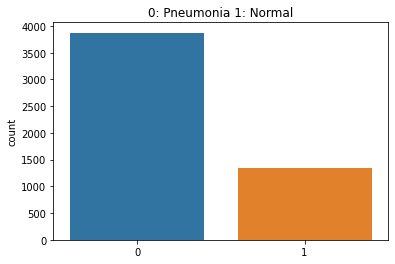

In [6]:
# Visualizing the data at hand
plt.title('0: Pneumonia 1: Normal')
sns.countplot(y_train)

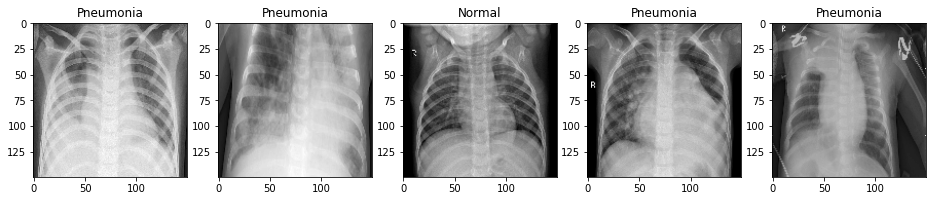

In [7]:
# Visualizing 5 random examples from training data
fig, axs = plt.subplots(1, 5, figsize = (16, 10))

for i in range(5):
    index = np.random.randint(0, len(x_train))
    axs[i].imshow(x_train[index].reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')
    label = 'Pneumonia' if y_train[index] == 0 else 'Normal'
    axs[i].set_title(label)

In [8]:
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1) # (No. of Examples, Image Width, Image Height, No. of Color Channels)
x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [9]:
def RandomPerspectiveAug(image):
    image = torch.tensor(image).view(1, 150, 150)
    return (T.PILToTensor()(T.RandomPerspective(distortion_scale = 0.2, p = 1)(T.ToPILImage()(image))))
    
def RandomRotationAug(image):
    image = torch.tensor(image).view(1, 150, 150)
    return (T.PILToTensor()(T.RandomRotation(degrees = (0, 30))(T.ToPILImage()(image))))

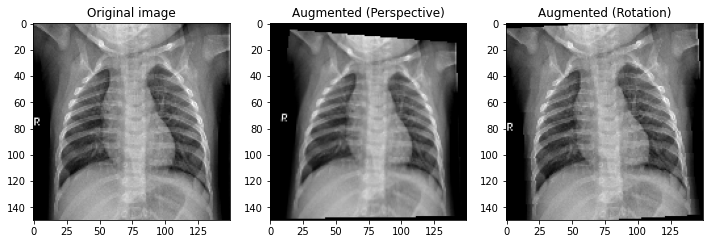

In [10]:
# Data Augmentation by Random Perpective to increase training data
# Grab random 1000 images of non-pneumonial x-rays
normal_examples_idx = [idx for idx, label in enumerate(y_train) if label == 1]

# Sample augmentation
sample_image = x_train[np.random.choice(normal_examples_idx)]
sample_perspective_aug = RandomPerspectiveAug(sample_image)
sample_rotation_aug = RandomRotationAug(sample_image)

fig, axs = plt.subplots(1, 3, figsize = (12, 10))
axs[0].imshow(sample_image.reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')
axs[0].set_title('Original image')
axs[1].imshow(sample_perspective_aug.reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')
axs[1].set_title('Augmented (Perspective)')
axs[2].imshow(sample_rotation_aug.reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')
axs[2].set_title('Augmented (Rotation)')

# Apply both augmentations to 1000 samples
perspective_aug_images = [RandomPerspectiveAug(image) for image in x_train[np.random.choice(normal_examples_idx, size = 1000)]]
rotation_aug_images = [RandomRotationAug(image) for image in x_train[np.random.choice(normal_examples_idx, size = 1000)]]

In [11]:
perspective_aug_images = torch.cat(perspective_aug_images, dim = 0)
rotation_aug_images = torch.cat(rotation_aug_images, dim = 0)

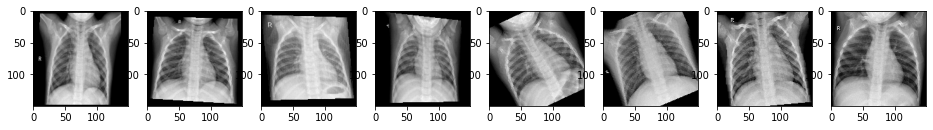

In [12]:
#Augmented Images
fig, axs = plt.subplots(1, 8, figsize = (16, 10))
for i in range(4):
    index = np.random.randint(0, len(perspective_aug_images))
    axs[i].imshow(perspective_aug_images[index].reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')
for i in range(4):
    index = np.random.randint(0, len(rotation_aug_images))
    axs[4 + i].imshow(rotation_aug_images[index].reshape(IMG_SIZE, IMG_SIZE), cmap = 'gray')

In [13]:
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)

x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)

In [14]:
# Append the augmentations to the training set
x_train = torch.cat((x_train.squeeze(3), perspective_aug_images / 255., rotation_aug_images / 255.)).unsqueeze(3)
y_train = torch.cat((y_train, torch.ones(len(perspective_aug_images) + len(perspective_aug_images))))

In [15]:
x_train = np.array(x_train).repeat(3, axis = -1)
x_val = np.array(x_val).repeat(3, axis = -1)
x_test = np.array(x_test).repeat(3, axis = -1)

x_train = torch.tensor(x_train).view(-1, 3, 150, 150)
x_val = torch.tensor(x_val).view(-1, 3, 150, 150)
x_test = torch.tensor(x_test).view(-1, 3, 150, 150)

In [16]:
train_set = [example for example in zip(x_train, y_train)]
val_set = [example for example in zip(x_val, y_val)]
test_set = [example for example in zip(x_test, y_test)]

In [17]:
train_loader = DataLoader(train_set, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_set, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 8, shuffle = True)

In [18]:
class detect_model(nn.Module):
    def __init__(self):
        super(detect_model, self).__init__()
        self.vgg = models.vgg16(pretrained = True, progress = True).features[:-1]
        self.classify = nn.Sequential(
            nn.Conv2d(self.vgg[-2].out_channels, 256, kernel_size = 3),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(num_features = 256),
            nn.Conv2d(256, 128, kernel_size = 3),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
            #nn.MaxPool2d(kernel_size = 1, stride = 1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = 1, stride = 1),
            nn.Conv2d(128, 64, 3),
            nn.Flatten(),
            nn.Linear(in_features = 64, out_features = 128),
            nn.ReLU(inplace = True),
            nn.Linear(in_features = 128, out_features = 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.Linear(in_features = 128, out_features = 64),
            nn.ReLU(inplace = True),
            nn.Linear(in_features = 64, out_features = 1)
        )
        self._freeze_params()
    def _freeze_params(self):
        for param in self.vgg[:23].parameters():
            param.requires_grad = False
    def forward(self, x):
        out = self.vgg(x)
        out = self.classify(out)
        return out
    

In [19]:
class detect_model_2(nn.Module):
    def __init__(self):
        super(detect_model_2, self).__init__()
        self.vgg = models.vgg16(pretrained = True, progress = True).features[:-1]
        self.classify = nn.Sequential(
            nn.Conv2d(self.vgg[-2].out_channels, 256, kernel_size = 3),
            nn.ReLU(inplace = True),
            #nn.BatchNorm2d(num_features = 256),
            nn.Conv2d(256, 128, kernel_size = 3),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            #nn.BatchNorm2d(128),
            #nn.MaxPool2d(kernel_size = 1, stride = 1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace = True),
            #nn.BatchNorm2d(128),
            #nn.MaxPool2d(kernel_size = 1, stride = 1),
            nn.Flatten(),
            nn.Linear(in_features = 64, out_features = 128),
            nn.ReLU(inplace = True),
            nn.Linear(in_features = 128, out_features = 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.Linear(in_features = 128, out_features = 64),
            nn.ReLU(inplace = True),
            nn.Linear(in_features = 64, out_features = 1)
        )
        self._freeze_params()
    def _freeze_params(self):
        for param in self.vgg[:23].parameters():
            param.requires_grad = False
    def forward(self, x):
        out = self.vgg(x)
        out = self.classify(out)
        return out

In [20]:
detect_model_2()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

detect_model_2(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [21]:
model = detect_model_2()
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
loss_func = nn.BCEWithLogitsLoss()
loss_vals = []
accuracy_vals = [0]
#model.train()
for epoch in range(5):
    
    loss_val = 0
    correct = 0
    count = 0
    
    #scheduler.step()

    for batch in tqdm(train_loader):
        images, labels = batch
        images, labels = images.to('cuda'), labels.to('cuda')
        labels = labels.unsqueeze(dim = 1)
        prediction = model(images.float())
        loss = loss_func(prediction, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_val += loss.item()
        count += len(labels)
        correct += (((prediction.sigmoid() > 0.5).int().eq(labels)).sum())
        
    accuracy = correct / count
    
    loss_vals.append(loss_val)
    accuracy_vals.append(accuracy.detach().cpu().numpy())
    
    print('Epoch:', epoch, ' Loss:', loss_val, ' Accuracy:', accuracy)

100%|██████████| 113/113 [00:21<00:00,  5.20it/s]


Epoch: 0  Loss: 44.71655074134469  Accuracy: tensor(0.8085, device='cuda:0')


100%|██████████| 113/113 [00:15<00:00,  7.34it/s]


Epoch: 1  Loss: 20.349847048521042  Accuracy: tensor(0.9293, device='cuda:0')


100%|██████████| 113/113 [00:15<00:00,  7.39it/s]


Epoch: 2  Loss: 14.356913533061743  Accuracy: tensor(0.9545, device='cuda:0')


100%|██████████| 113/113 [00:15<00:00,  7.31it/s]


Epoch: 3  Loss: 11.787716824561357  Accuracy: tensor(0.9623, device='cuda:0')


100%|██████████| 113/113 [00:15<00:00,  7.37it/s]

Epoch: 4  Loss: 11.451783553697169  Accuracy: tensor(0.9624, device='cuda:0')


In [22]:
torch.save(model, 'pneumonia_detector_model.h5')

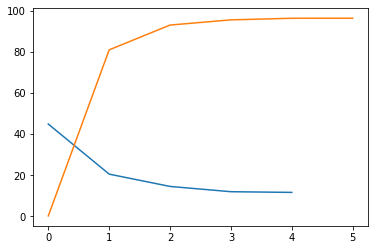

In [23]:
plt.plot(loss_vals)
plt.plot([x*100 for x in accuracy_vals])
plt.show()

In [24]:
preds = (model(x_val.cuda().float()).sigmoid() > 0.5).int()
accuracy_score(y_val, preds.detach().cpu().numpy().reshape(-1))

0.875

In [25]:
print(preds.view(-1))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0',
       dtype=torch.int32)


In [26]:
preds = (model(x_test.cuda().float()).sigmoid() > 0.5).int()
accuracy_score(y_test, preds.detach().cpu().numpy().reshape(-1))

0.780448717948718

[[382   8]
 [129 105]]


<AxesSubplot:>

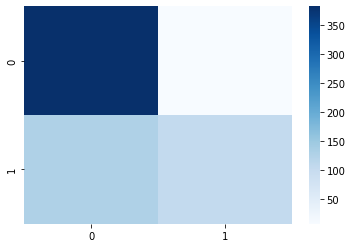

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds.detach().cpu().numpy().reshape(-1))
import seaborn as sns
print(cm)
sns.heatmap(cm, cmap = 'Blues')

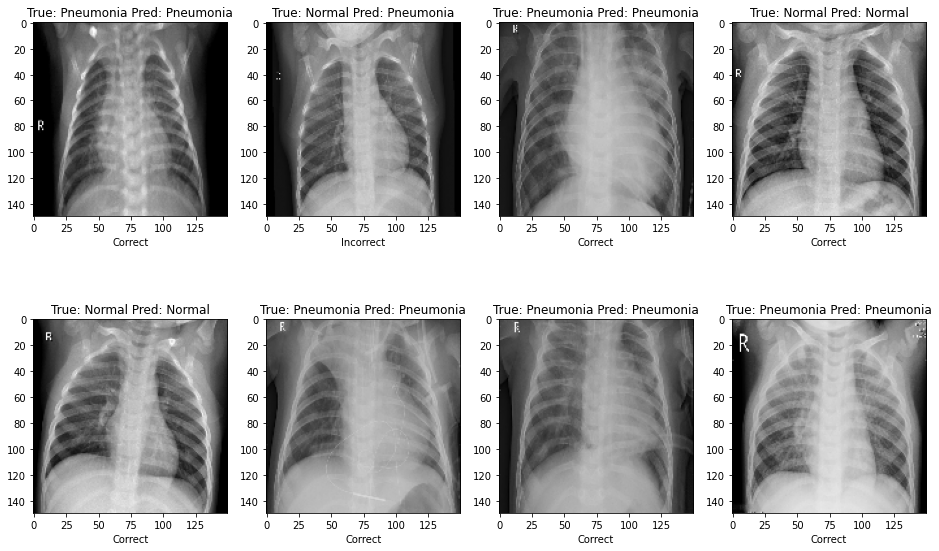

In [28]:
images, labels = next(iter(test_loader))
prediction = (model(images.float().to('cuda')).sigmoid() > 0.5).int().detach().cpu().numpy().reshape(-1)        
fig, axs = plt.subplots(2, 4, figsize = (16, 10))

for i in range(2):
    for j in range(4):
        axs[i][j].imshow(images[j + (i * 4)].view(150,150, 3))
        prediction_hyp = 'Pneumonia' if prediction[j + (i * 4)] == 0 else 'Normal'
        label = 'Pneumonia' if labels[j + (i * 4)] == 0 else 'Normal'
        title = 'True: ' + label + ' Pred: ' + str(prediction_hyp)
        axs[i][j].set_title(title)
        correct = 'Correct' if label == str(prediction_hyp) else 'Incorrect'
        axs[i][j].set_xlabel(correct)